<a href="https://colab.research.google.com/github/raulsomazabracho/Forecasting/blob/main/Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [341]:
# Manipulación de data
import pandas as pd
import numpy as np

# Visualización de data
import matplotlib.pyplot as plt
import seaborn as sns

# Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# Advertencias
import warnings 
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore',ConvergenceWarning)

# Tiempo de ejecución
import time

In [342]:
start_time = time.time()

# Lectura Dataset

Dataset publico de ventas mensuales de una tienda

In [343]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


columna "date" en formato fecha "%Y-%m-%d" y no hay faltantes

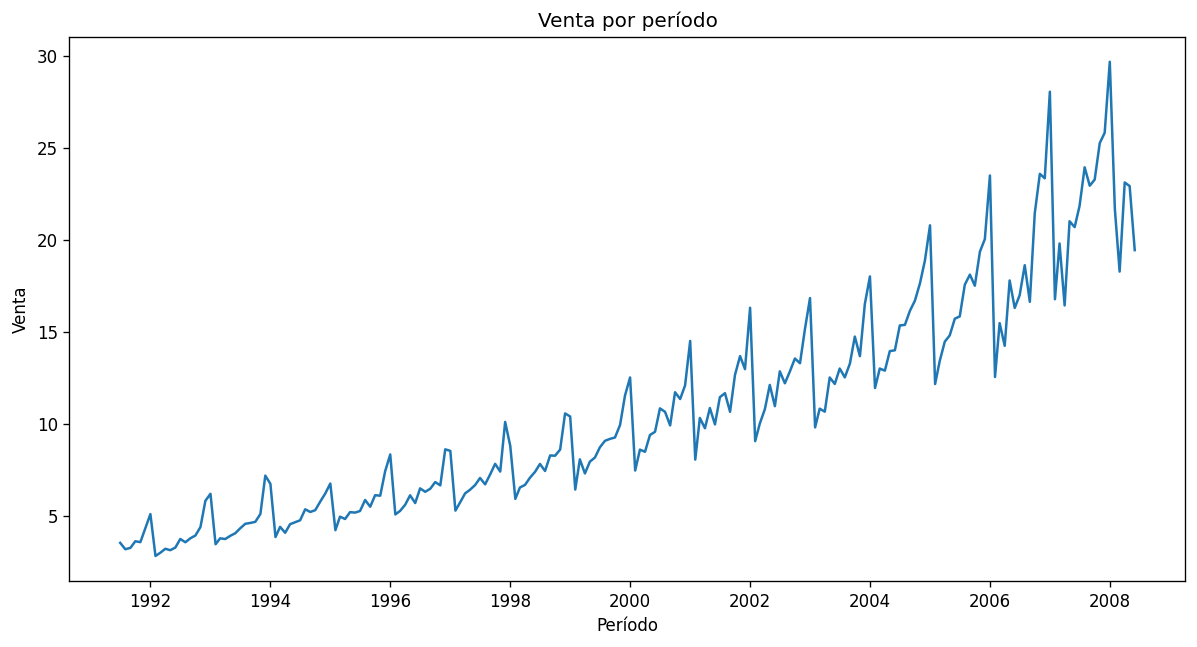

In [344]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(df.date,df.value)
plt.xlabel("Período")
plt.ylabel("Venta")
plt.title("Venta por período")
plt.show()

Se observa estacionalidad y tendencia positiva en los datos

# Manipulación de Data

## Features de tiempo

In [345]:
# Funcion lamba que extrae el feature de tiempo adecuado de la columna "date"
df['day'] = df['date'].apply(lambda x:pd.Timestamp(x).strftime('%d'))
df['month'] = df['date'].apply(lambda x:pd.Timestamp(x).strftime('%m'))
df['year'] = df['date'].apply(lambda x:pd.Timestamp(x).strftime('%Y'))
df['year-month'] = df['date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m'))
df.head()

,date,value,day,month,year,year-month
0,1991-07-01,3.526591,01,07,1991,1991-07
1,1991-08-01,3.180891,01,08,1991,1991-08
2,1991-09-01,3.252221,01,09,1991,1991-09
3,1991-10-01,3.611003,01,10,1991,1991-10
4,1991-11-01,3.565869,01,11,1991,1991-11


## Creación Dataframe datos anuales

In [346]:
# Agrupamos por "year" los datos y sumamos las columnas númericas, reseteamos index para ordenar
anual = df.groupby('year').sum().reset_index()
anual.head()

,year,value
0,1991,21.442946
1,1992,45.686946
2,1993,55.532688
3,1994,60.816080
4,1995,67.326599


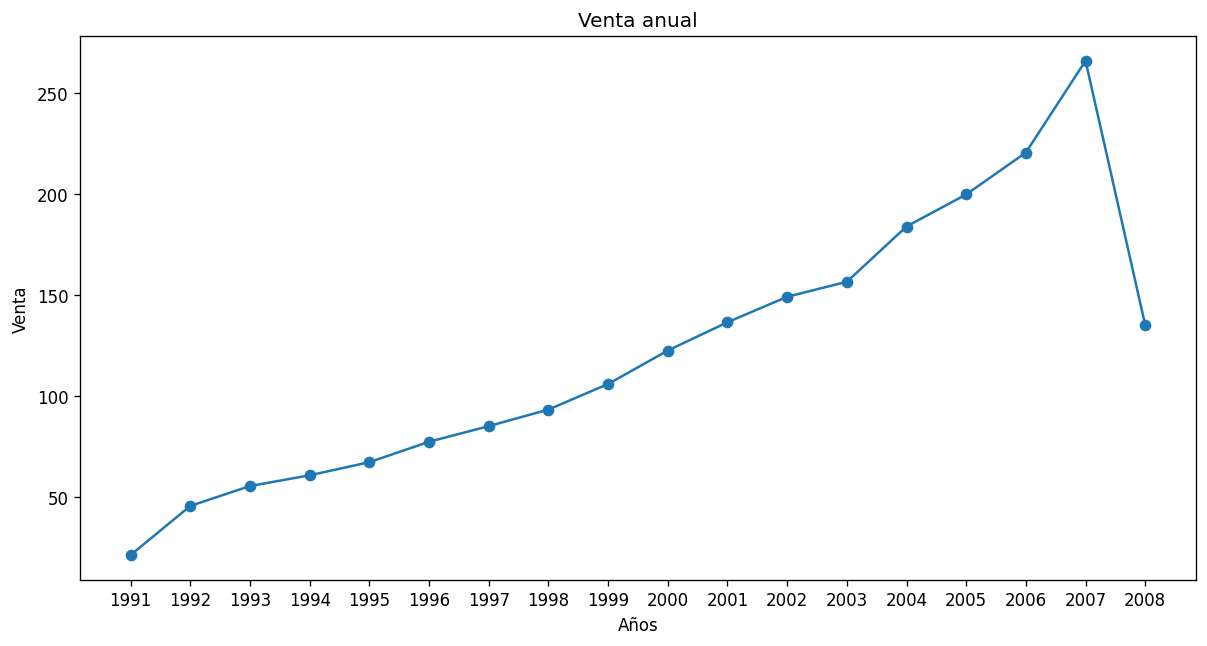

In [347]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(anual.year,anual.value, '-o')
plt.xlabel("Años")
plt.ylabel("Venta")
plt.title("Venta anual")
plt.show()

# Moving Average (Promedios Móviles)

## Creación

Crearemos una columna "MA (moving average)" que contenga el promedio de ventas de los 3 años.

Esto se hace con la función de Pandas ".rolling()" y se le coloca la duración del período del cálculo ("window").

Para que no tome en cuenta los primeros 2 meses se coloca la función "shift"

In [348]:
# Creación feature movil
anual['MA'] = anual['value'].rolling(window = 3).mean().shift(1)
anual

,year,value,MA
0,1991,21.442946,NaN
1,1992,45.686946,NaN
2,1993,55.532688,NaN
3,1994,60.816080,40.887527
4,1995,67.326599,54.011905
5,1996,77.397927,61.225122
6,1997,85.131672,68.513535
7,1998,93.310626,76.618732
8,1999,105.959043,85.280075
9,2000,122.496586,94.800447


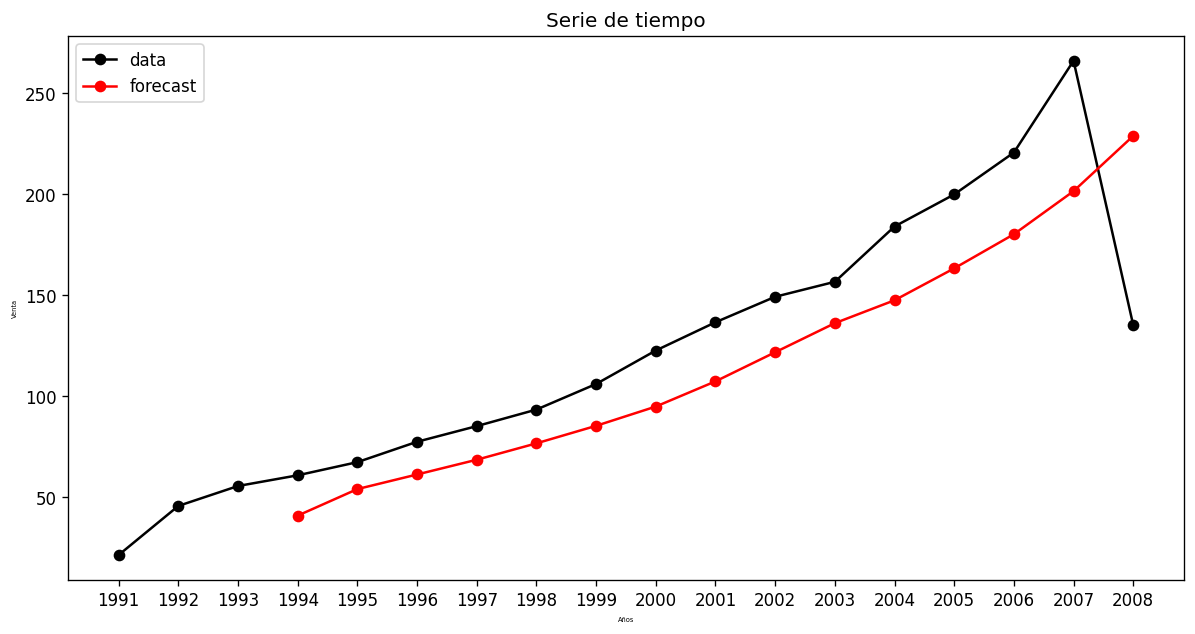

In [349]:
# Graficamos en rojo el promedio de venta en ventanas moviles y comparamos
plt.figure(figsize = [12,6])
plt.plot(anual.year,anual.value, '-o', color = 'black', label = 'data')
plt.plot(anual.year,anual.MA, '-o', color = 'red', label = 'forecast')
plt.xlabel("Años", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

Ya tenemos el forecast de datos conocidos, ahora debemos estimar el error y haremos la proyección a datos futuros

## Forecast 1 solo período

In [350]:
# Se agrega nueva fila al dataframe
# al ultimo año encontrado se le suma uno y comocamos 0 en los 2 valores numericos
anual.loc[len(anual)] = [int(anual.iloc[len(anual)-1][0])+1,0,0]
anual

,year,value,MA
0,1991,21.442946,NaN
1,1992,45.686946,NaN
2,1993,55.532688,NaN
3,1994,60.816080,40.887527
4,1995,67.326599,54.011905
5,1996,77.397927,61.225122
6,1997,85.131672,68.513535
7,1998,93.310626,76.618732
8,1999,105.959043,85.280075
9,2000,122.496586,94.800447


Para predecir repetimos el codigo de calcular los períodos moviles anteriores

In [351]:
# Predicción
anual['MA'] = anual['value'].rolling(window = 3).mean().shift(1)

#Ordernar formato de los demás features
anual['year'] = anual['year'].astype(int)
anual['value'] = anual['value'].astype(float)
anual['MA'] = anual['MA'].astype(float)
anual

,year,value,MA
0,1991,21.442946,NaN
1,1992,45.686946,NaN
2,1993,55.532688,NaN
3,1994,60.816080,40.887527
4,1995,67.326599,54.011905
5,1996,77.397927,61.225122
6,1997,85.131672,68.513535
7,1998,93.310626,76.618732
8,1999,105.959043,85.280075
9,2000,122.496586,94.800447


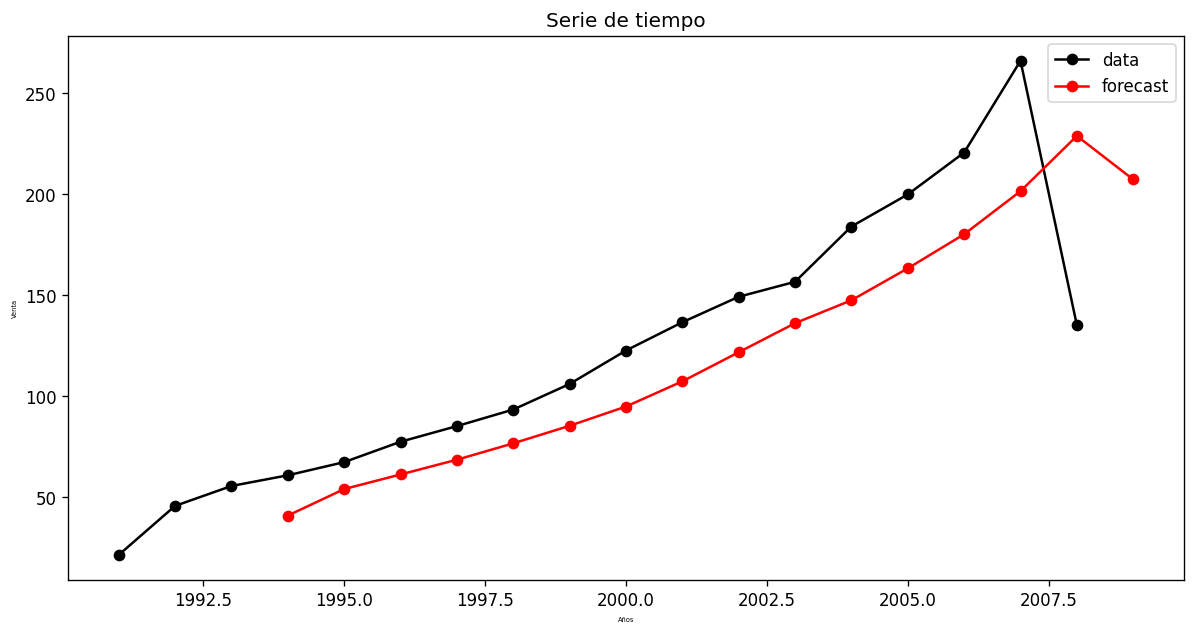

In [352]:
# Graficamos en rojo el promedio de venta en ventanas moviles y comparamos

# Se le cambia el tamaño a la serie para que no grafique el 0 de value en la ultima observación
plt.figure(figsize = [12,6])
plt.plot(anual['year'][:-1],anual['value'][:-1], '-o', color = 'black', label = 'data')
plt.plot(anual['year'],anual['MA'], '-o', color = 'red', label = 'forecast')
plt.xlabel("Años", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

## Forecast mucho períodos

In [353]:
# Se colocan la cantidad de períodos y se repite en mismo codigo de la parte anterior dentro de un for
períodos = 2

for n in range(períodos):
  anual.loc[len(anual)] = [int(anual.iloc[len(anual)-1][0])+1,0,0]
anual

,year,value,MA
0,1991,21.442946,NaN
1,1992,45.686946,NaN
2,1993,55.532688,NaN
3,1994,60.816080,40.887527
4,1995,67.326599,54.011905
5,1996,77.397927,61.225122
6,1997,85.131672,68.513535
7,1998,93.310626,76.618732
8,1999,105.959043,85.280075
9,2000,122.496586,94.800447


In [354]:
# Predicción
anual['MA'] = anual['value'].rolling(window = 3).mean().shift(1)

#Ordernar formato de los demás features
anual['year'] = anual['year'].astype(int)
anual['value'] = anual['value'].astype(float)
anual['MA'] = anual['MA'].astype(float)
anual

,year,value,MA
0,1991,21.442946,NaN
1,1992,45.686946,NaN
2,1993,55.532688,NaN
3,1994,60.816080,40.887527
4,1995,67.326599,54.011905
5,1996,77.397927,61.225122
6,1997,85.131672,68.513535
7,1998,93.310626,76.618732
8,1999,105.959043,85.280075
9,2000,122.496586,94.800447


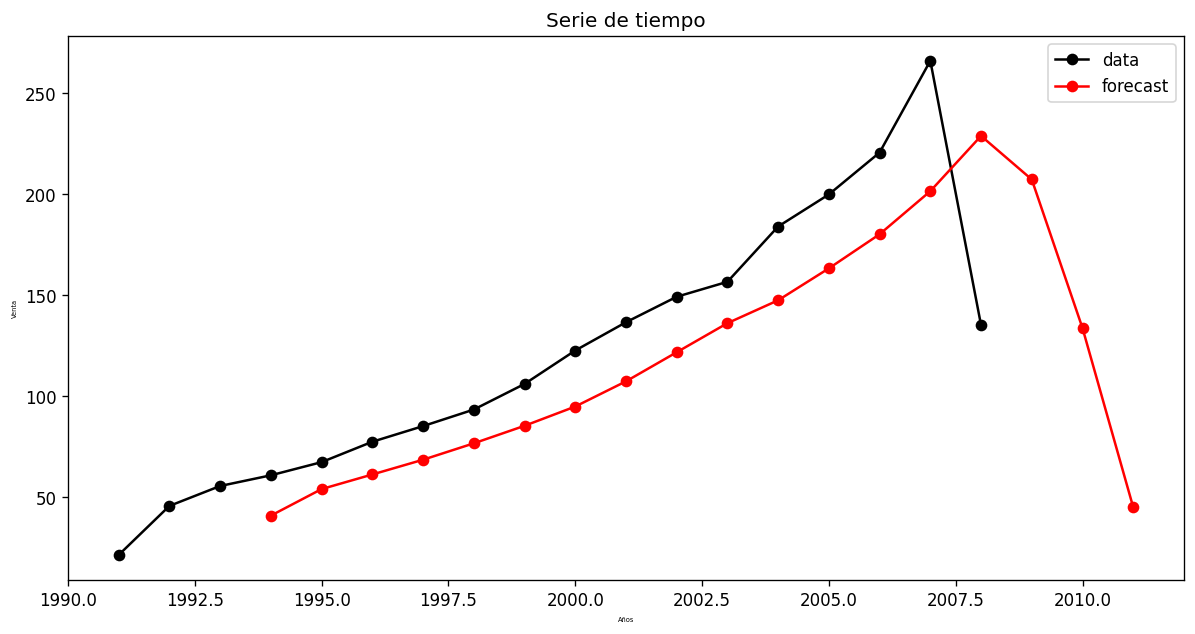

In [355]:
# Graficamos en rojo el promedio de venta en ventanas moviles y comparamos

# Se le cambia el tamaño a la serie para que no grafique los 0 de value en la ultimas observaciones
plt.figure(figsize = [12,6])
plt.plot(anual['year'][:-3],anual['value'][:-3], '-o', color = 'black', label = 'data')
plt.plot(anual['year'],anual['MA'], '-o', color = 'red', label = 'forecast')
plt.xlabel("Años", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

# Exponential Smoothing (Suavización Exponencial)

In [356]:
# Volvemos a transformar el dataset origianl sin las modificaciones del forecast anterior
anual = df.groupby('year').sum().reset_index()
anual['MA'] = anual['value'].rolling(window = 3).mean().shift(1)
anual

,year,value,MA
0,1991,21.442946,NaN
1,1992,45.686946,NaN
2,1993,55.532688,NaN
3,1994,60.816080,40.887527
4,1995,67.326599,54.011905
5,1996,77.397927,61.225122
6,1997,85.131672,68.513535
7,1998,93.310626,76.618732
8,1999,105.959043,85.280075
9,2000,122.496586,94.800447


## Creación

In [357]:
# Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

In [358]:
# Creamos el modelo diciendole que busque los mejores parametros
modelo =  SimpleExpSmoothing(anual['value']).fit(optimized = True)

#Creamos nueva columna con los valores ajustados del modelo
anual['ES'] = modelo.fittedvalues
anual

,year,value,MA,ES
0,1991,21.442946,NaN,28.933598
1,1992,45.686946,NaN,23.481919
2,1993,55.532688,NaN,39.642687
3,1994,60.816080,40.887527,51.207393
4,1995,67.326599,54.011905,58.200573
5,1996,77.397927,61.225122,64.842474
6,1997,85.131672,68.513535,73.980304
7,1998,93.310626,76.618732,82.096244
8,1999,105.959043,85.280075,90.258045
9,2000,122.496586,94.800447,101.685195


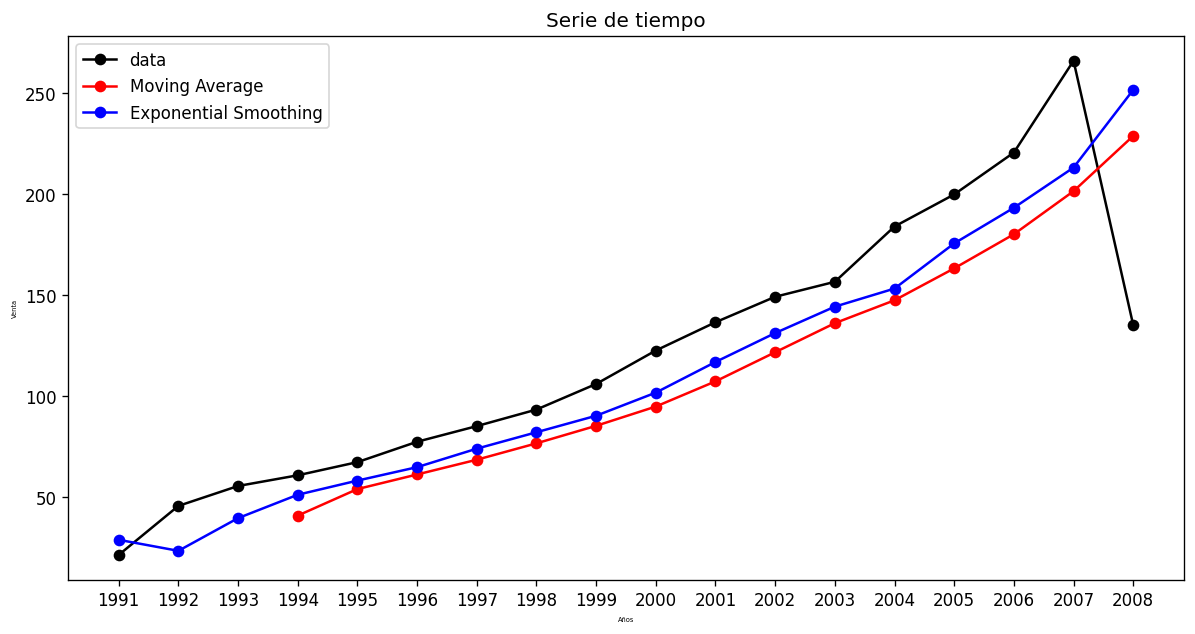

In [359]:
# Graficamos en rojo el promedio de venta en ventanas moviles y comparamos
plt.figure(figsize = [12,6])
plt.plot(anual['year'],anual['value'], '-o', color = 'black', label = 'data')
plt.plot(anual['year'],anual['MA'], '-o', color = 'red', label = 'Moving Average')
plt.plot(anual['year'],anual['ES'], '-o', color = 'blue', label = 'Exponential Smoothing')

plt.xlabel("Años", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

## Error

In [360]:
#MSE
from sklearn.metrics import mean_squared_error as MSE

In [361]:
#Valor verdadero y pronosticos (elimino también valores Nan)
y_true = anual['value']

y_ma = anual['MA']
y_es = anual['ES']

In [362]:
#Error Medias Moviles
MSE(y_true[3:],y_ma.dropna())

1453.9206702093313

In [363]:
# Error Exponential Smoothing
MSE(y_true,y_es)

1195.0229335122815

In [364]:
# Visualizamos los parametros que el modelo escogió
modelo.summary()

Dep. Variable:,value,No. Observations:,18
Model:,SimpleExpSmoothing,SSE,21510.413
Optimized:,True,AIC,131.547
Trend:,None,BIC,133.327
Seasonal:,None,AICC,134.623
Seasonal Periods:,None,Date:,"Sun, 19 Jun 2022"
Box-Cox:,False,Time:,02:14:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7277977,alpha,True
initial_level,28.933598,l.0,True


## Forecast

In [365]:
#le indicamos al modelo cuantos períodos queremos pronosticas
pred = modelo.forecast(5)
pred

18    166.696982
19    166.696982
20    166.696982
21    166.696982
22    166.696982
dtype: float64

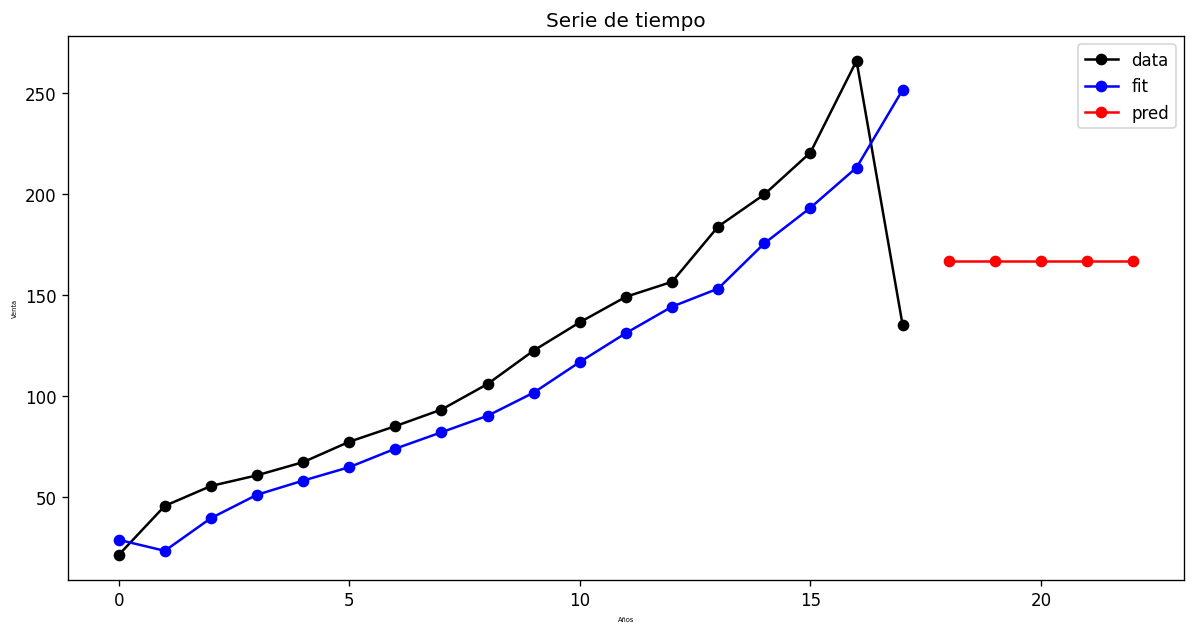

In [366]:
# Graficamos el entrenamiento y el forecast
plt.figure(figsize = [12,6])
plt.plot(anual.index,anual['value'], '-o', color = 'black', label = 'data')
plt.plot(anual.index,anual['ES'], '-o', color = 'blue', label = 'fit')
plt.plot(pred, '-o', color = 'red', label = 'pred')

plt.xlabel("Años", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

No tiene buen aspecto el grafico, vamos a mejorarlo

In [367]:
#Creamos nueva serie de tiempo concatenando todo
expo_s = pd.concat([anual['ES'],pred])
expo_s

0      28.933598
1      23.481919
2      39.642687
3      51.207393
4      58.200573
5      64.842474
6      73.980304
7      82.096244
8      90.258045
9     101.685195
10    116.831678
11    131.122542
12    144.181848
13    153.120961
14    175.448321
15    193.066320
16    212.926723
17    251.348797
18    166.696982
19    166.696982
20    166.696982
21    166.696982
22    166.696982
dtype: float64

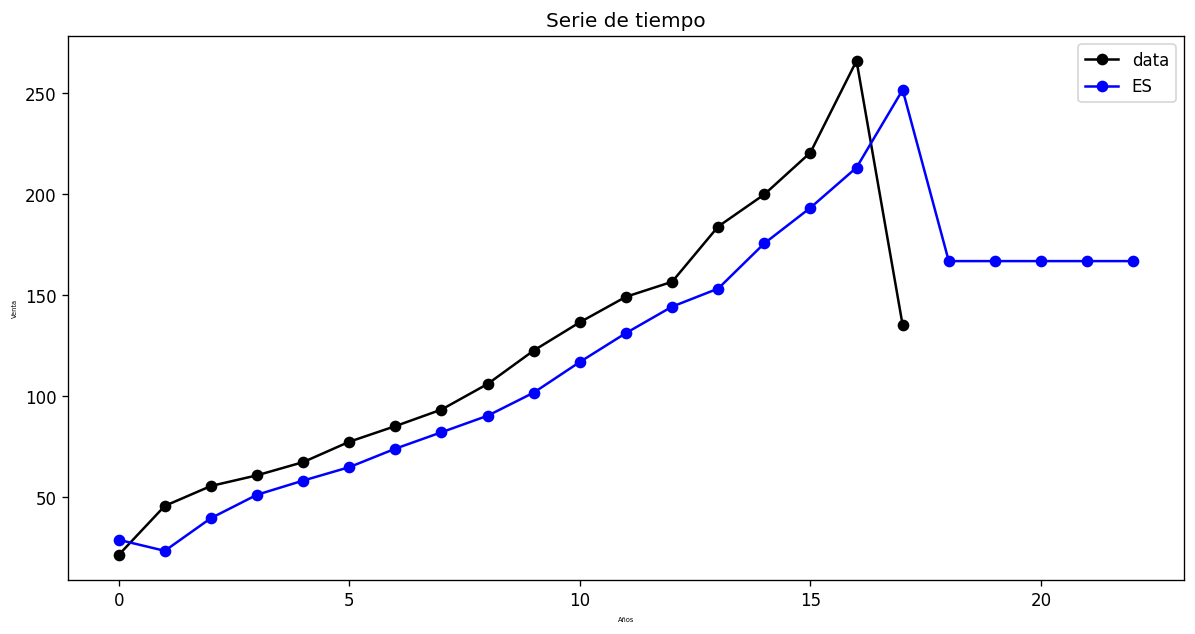

In [368]:
# Graficamos el entrenamiento y el forecast
plt.figure(figsize = [12,6])
plt.plot(anual.index,anual['value'], '-o', color = 'black', label = 'data')
plt.plot(expo_s, '-o', color = 'blue', label = 'ES')

plt.xlabel("Años", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

## Forecast Data sin agrupar por año

In [369]:
# Creamos el modelo diciendole que busque los mejores parametros
modelo =  SimpleExpSmoothing(df['value']).fit(optimized = True)

#Creamos nueva columna con los valores ajustados del modelo
df['ES'] = modelo.fittedvalues

# predecimos 30 meses
pred = modelo.forecast(30)

#Concatenmos
expo_s = pd.concat([df['ES'],pred])


In [370]:
# Calculamos el error 
#MSE
from sklearn.metrics import mean_squared_error as MSE
#MAPE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Error Exponential Smoothing
print("MSE : ", MSE(df['value'],df['ES']))
print("MAPE : ", MAPE(df['value'],df['ES']))

MSE :  4.024955370218677
MAPE :  0.13194162718805003


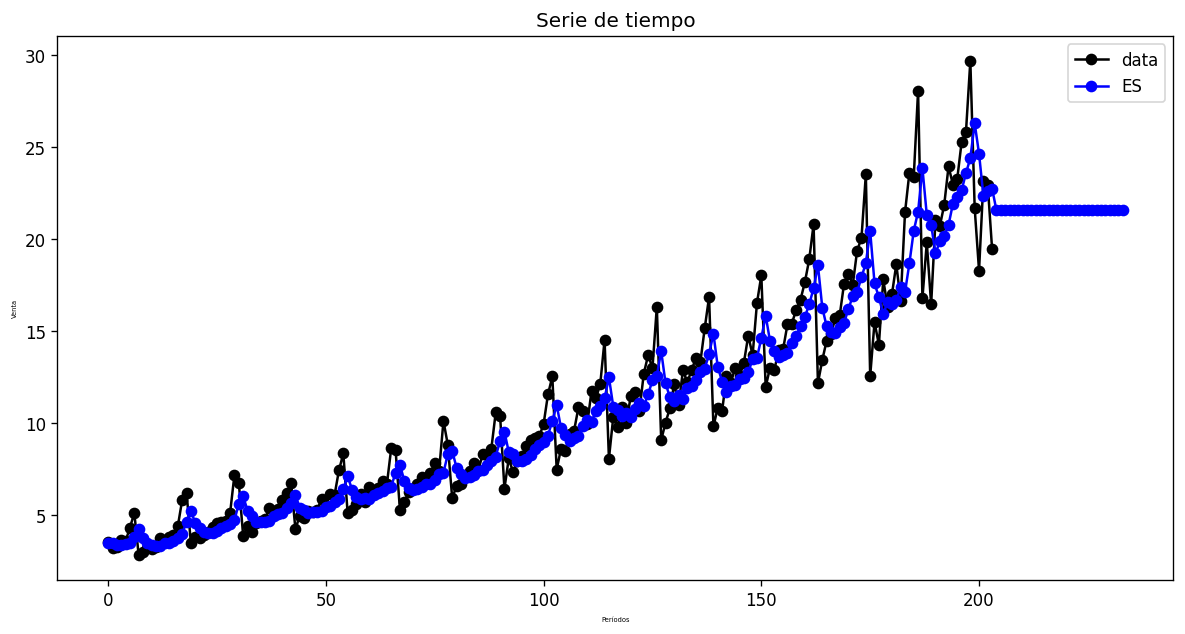

In [371]:
# Graficamos el entrenamiento y el forecast
plt.figure(figsize = [12,6])
plt.plot(df.index,df['value'], '-o', color = 'black', label = 'data')
plt.plot(expo_s, '-o', color = 'blue', label = 'ES')

plt.xlabel("Períodos", fontsize = 4)
plt.ylabel("Venta", fontsize = 4)
plt.title("Serie de tiempo")
plt.legend(loc = 'best')
plt.show()

# HOLT

Toma en cuenta tendencia pero no estacionalidad

## Lectura Dataset

In [372]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


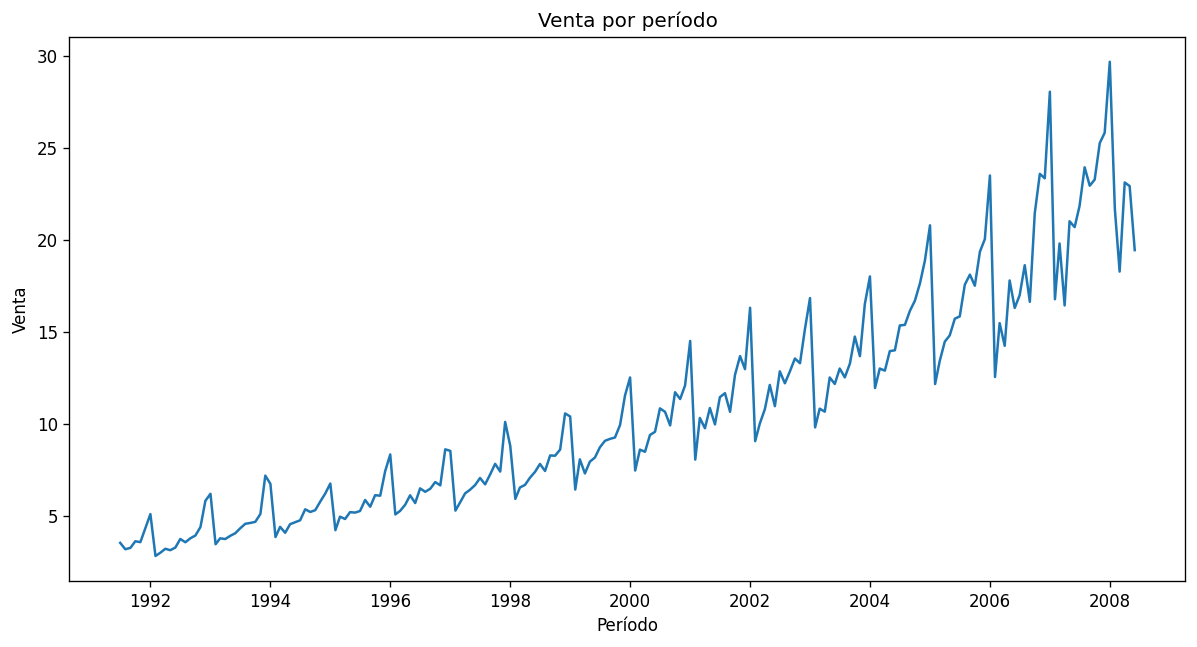

In [373]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(df.date,df.value)
plt.xlabel("Período")
plt.ylabel("Venta")
plt.title("Venta por período")
plt.show()

## Creación

In [374]:
# Separamos en train y test 70/30 aprox
#Dividiamos en un ratio 70/30 el train y validation
print("Longitud data total", len(df))


train = df.iloc[:160,:]
print("Longitud data de entrenamiento", len(train))

test = df.iloc[160:,:]
print("Longitud data de validación", len(test))


len(train)
train.head()

Longitud data total 204
Longitud data de entrenamiento 160
Longitud data de validación 44


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [375]:
# Importamos Holt y compararemos con Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Creamos el modelo diciendole que busque los mejores parametros
modelo_1 =  Holt(train['value']).fit(optimized = True)

# predecimos 30 meses
pred_1 = modelo_1.forecast(44)

## Validación

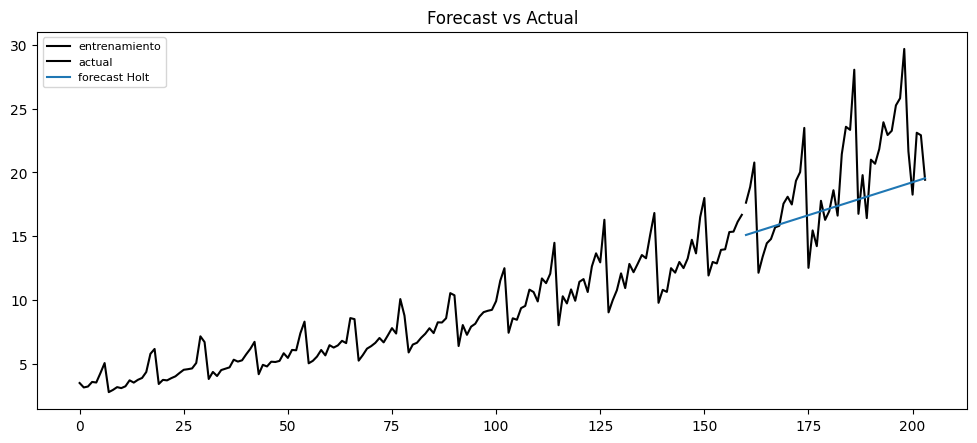

In [376]:
#Graficamos
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='entrenamiento',color = 'black')
plt.plot(test.value, label='actual', color = 'black')
plt.plot(pred_1, label='forecast Holt')
plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Error

In [377]:
# Error Holt - Winter
print("RMSE : ", MSE(pred_1,test.value, squared = False))
print("MAPE : ", MAPE(pred_1,test.value))

RMSE :  3.9832839621799696
MAPE :  0.1785556192951288


## Forecast

Ahora utilizamos todo el Dataset para predecir

In [378]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


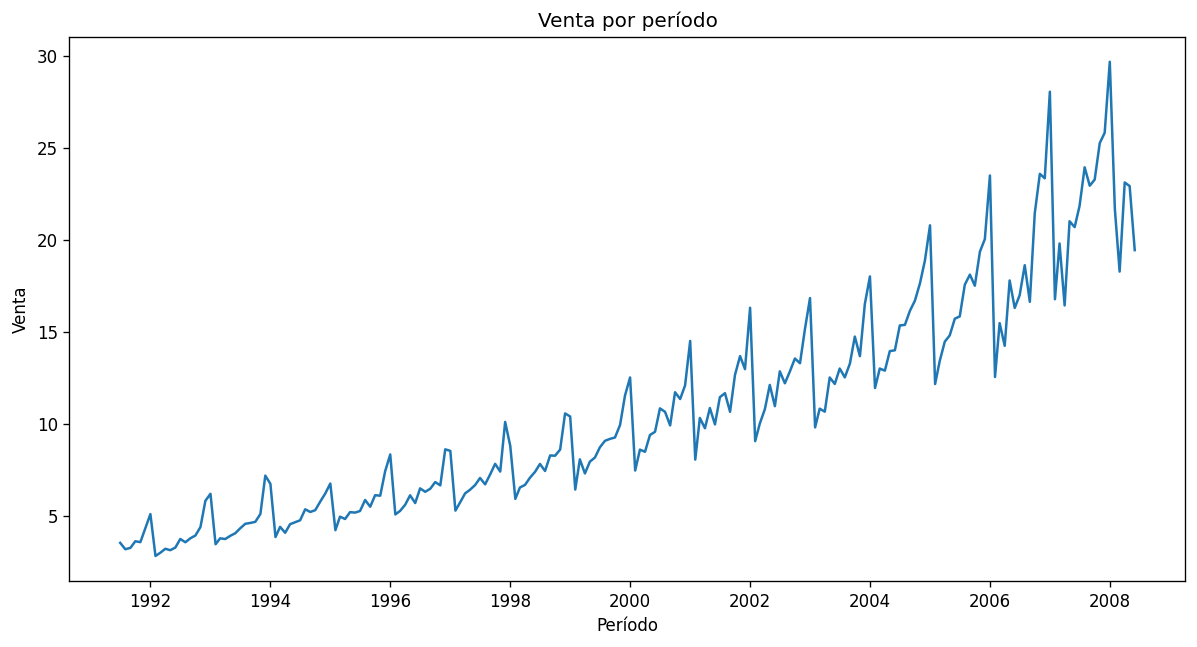

In [379]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(df.date,df.value)
plt.xlabel("Período")
plt.ylabel("Venta")
plt.title("Venta por período")
plt.show()

In [380]:
# Importamos Holt y compararemos con Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Creamos el modelo diciendole que busque los mejores parametros
modelo_1 =  SimpleExpSmoothing(df['value']).fit(optimized = True)
modelo_2 =  Holt(df['value']).fit(optimized = True)

#Creamos nueva columna con los valores ajustados del modelo
df['ES'] = modelo_1.fittedvalues
df['Holt'] = modelo_2.fittedvalues

# predecimos 30 meses
pred_1 = modelo_1.forecast(30)
pred_2 = modelo_2.forecast(30)

#Concatenmos
expo_s = pd.concat([df['ES'],pred_1])
holt_s = pd.concat([df['Holt'],pred_2])


In [381]:
# Calculamos el error 
#MSE
from sklearn.metrics import mean_squared_error as MSE
#MAPE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Error Exponential Smoothing
print("RMSE ES: ", MSE(df['value'],df['ES'], squared = True))
print("RMSE Holt: ", MSE(df['value'],df['Holt'], squared = True))
print("******")
print("MAPE ES : ", MAPE(df['value'],df['ES']))
print("MAPE Holt : ", MAPE(df['value'],df['Holt']))

RMSE ES:  4.024955370218677
RMSE Holt:  3.865013748287052
******
MAPE ES :  0.13194162718805003
MAPE Holt :  0.13650105723158265


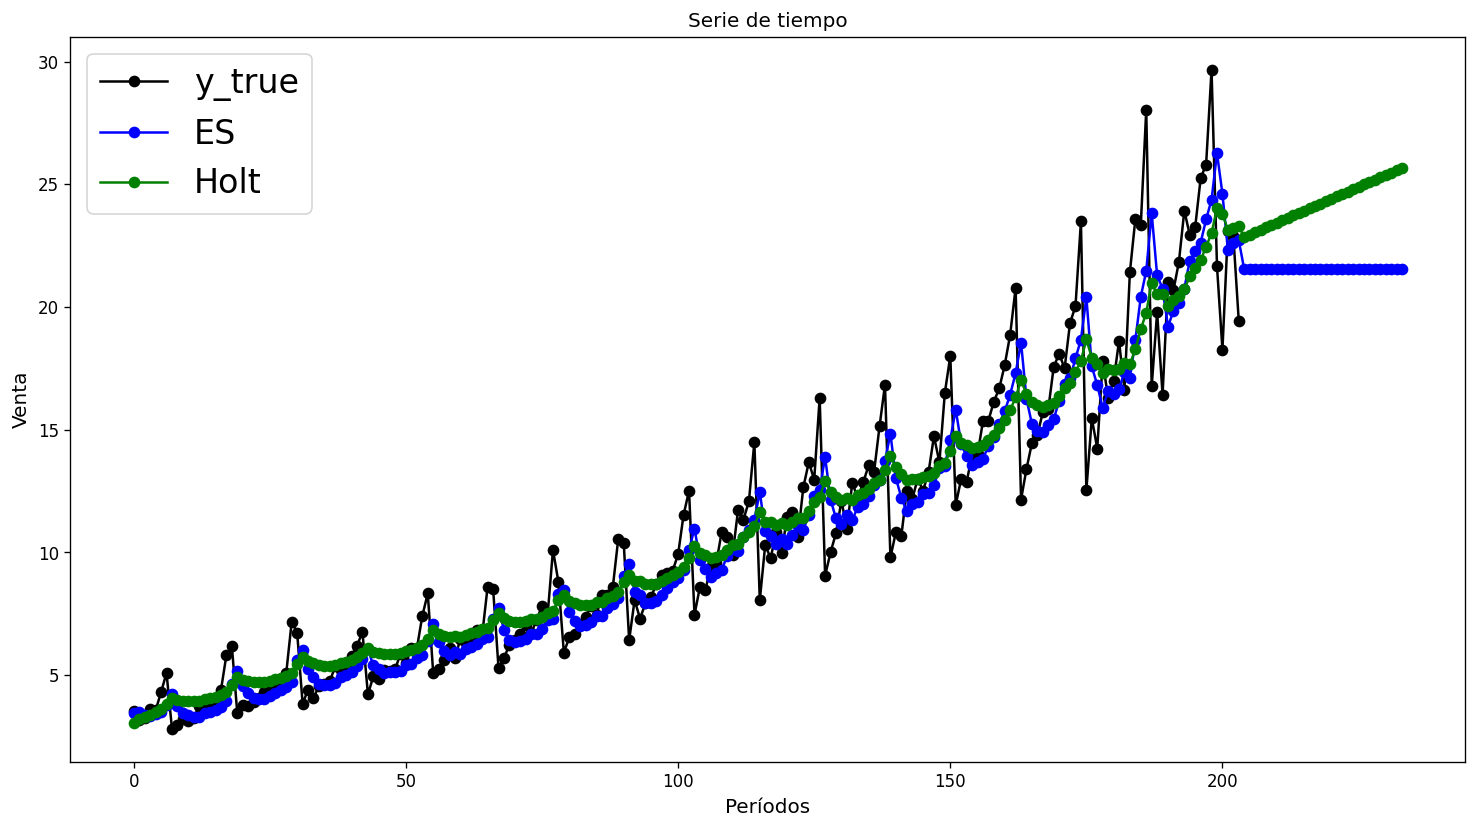

In [382]:
# Graficamos el entrenamiento y el forecast
plt.figure(figsize = [15,8])
plt.plot(df.index,df['value'], '-o',color = 'black', label = 'y_true')
plt.plot(expo_s, '-o', color = 'blue', label = 'ES')

plt.plot(holt_s, '-o',color = 'green', label = 'Holt')

plt.xlabel("Períodos", fontsize = 12)
plt.ylabel("Venta", fontsize = 12)
plt.title("Serie de tiempo")
plt.legend(loc = 'best', fontsize = 20)
plt.show()

# Holt- Winter

Tiene en cuenta tanto tendencia como estacionalidad

## Lectura Dataset

In [383]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


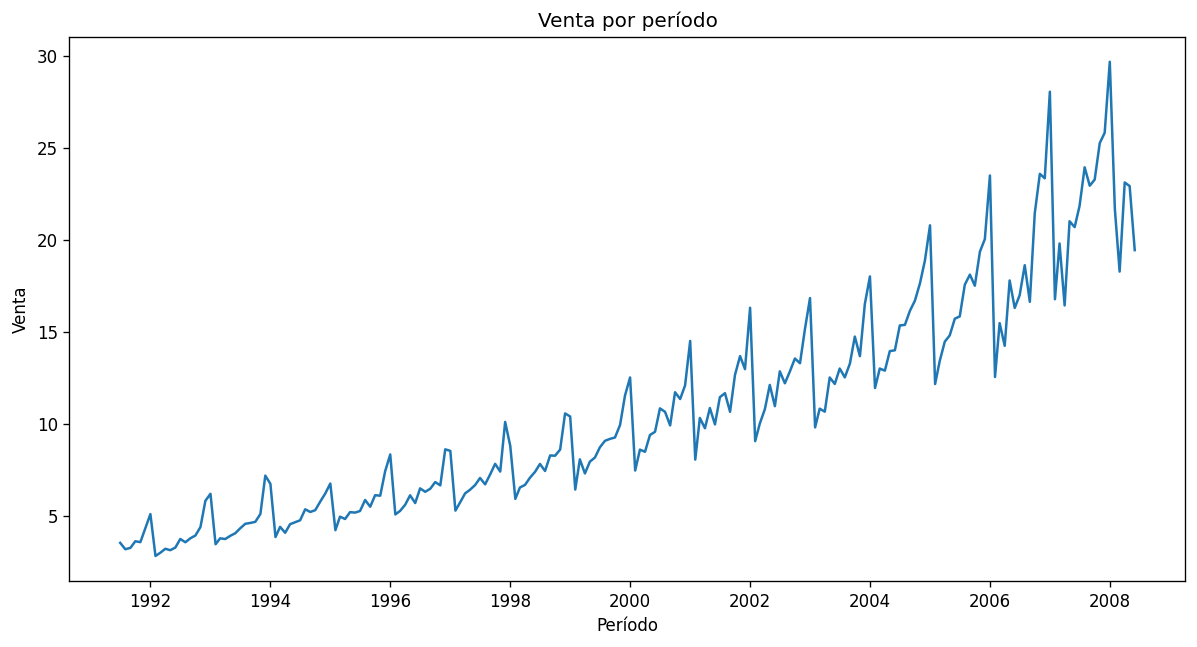

In [384]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(df.date,df.value)
plt.xlabel("Período")
plt.ylabel("Venta")
plt.title("Venta por período")
plt.show()

## Creación

In [385]:
# Separamos en train y test 70/30 aprox
#Dividiamos en un ratio 70/30 el train y validation
print("Longitud data total", len(df))


train = df.iloc[:160,:]
print("Longitud data de entrenamiento", len(train))

test = df.iloc[160:,:]
print("Longitud data de validación", len(test))


len(train)
train.head()

Longitud data total 204
Longitud data de entrenamiento 160
Longitud data de validación 44


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [386]:
# Importamos Holt y compararemos con Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Creamos el modelo diciendole que busque los mejores parametros
modelo_1 =  Holt(train['value']).fit(optimized = True)
modelo_2 =  ExponentialSmoothing(train['value'],seasonal_periods=12 ,trend= 'add', seasonal='add').fit(optimized = True)

# predecimos 30 meses
pred_1 = modelo_1.forecast(44)
pred_2 = modelo_2.forecast(44)

## Validación

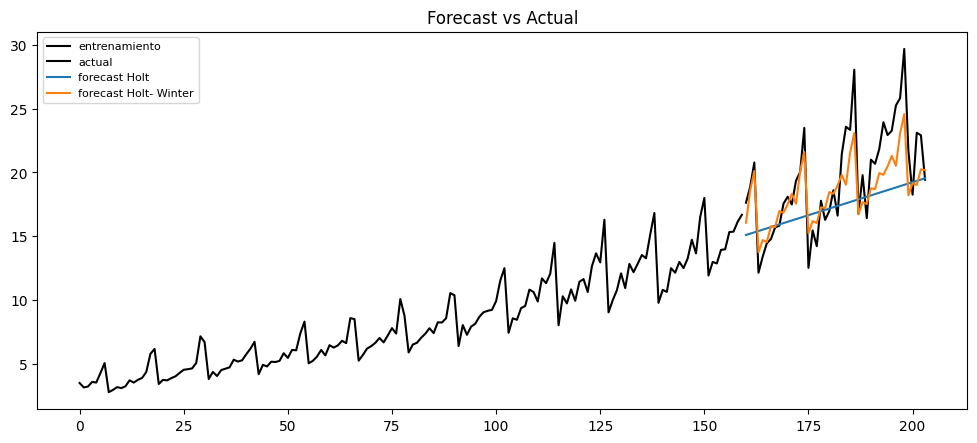

In [387]:
#Graficamos
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='entrenamiento',color = 'black')
plt.plot(test.value, label='actual', color = 'black')
plt.plot(pred_1, label='forecast Holt')
plt.plot(pred_2, label='forecast Holt- Winter')
plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Error

In [388]:
# Error Holt - Winter
print("RMSE : ", MSE(pred_2,test.value, squared = False))
print("MAPE : ", MAPE(pred_2,test.value))

RMSE :  2.2709439631184107
MAPE :  0.09456252227473037


## Forecast

Ahora utilizaremos todo el Dataset para predecir

In [389]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


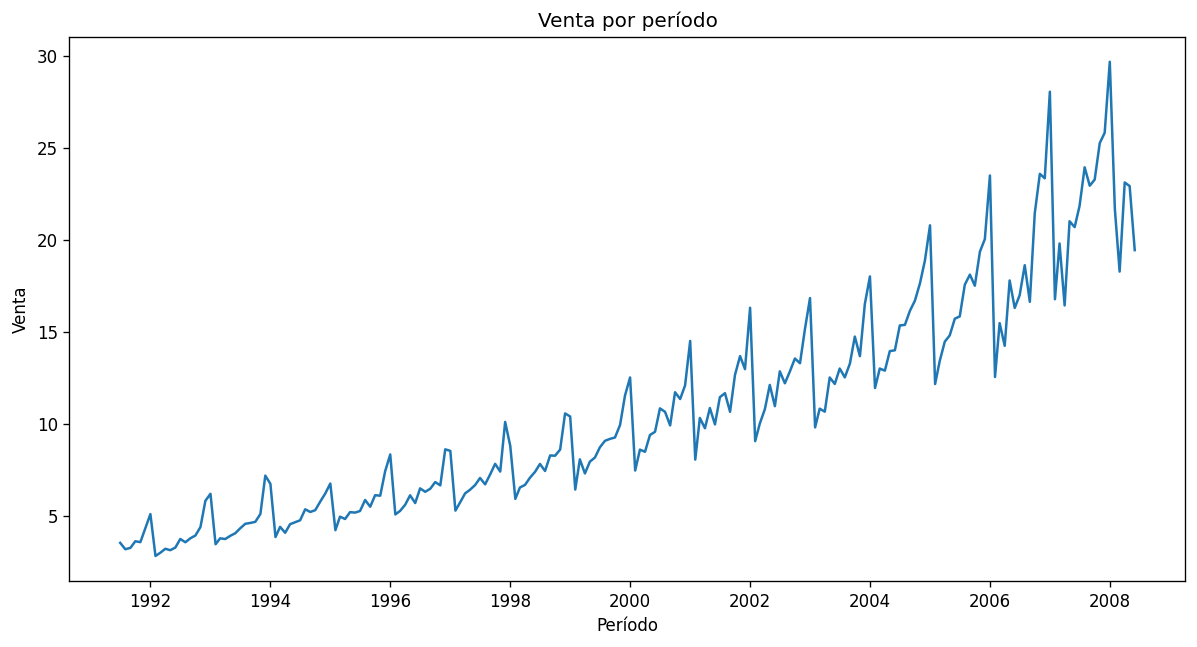

In [390]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(df.date,df.value)
plt.xlabel("Período")
plt.ylabel("Venta")
plt.title("Venta por período")
plt.show()

In [391]:
# Importamos Holt y compararemos con Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Creamos el modelo diciendole que busque los mejores parametros
modelo_1 =  Holt(df['value']).fit(optimized = True)
modelo_2 =  ExponentialSmoothing(df['value'],seasonal_periods=12 ,trend= 'add', seasonal='add').fit(optimized = True)


#Creamos nueva columna con los valores ajustados del modelo
df['Holt'] = modelo_1.fittedvalues
df['Holt-Winter'] = modelo_2.fittedvalues

# predecimos 30 meses
pred_1 = modelo_1.forecast(30)
pred_2 = modelo_2.forecast(30)

#Concatenmos
holt_s = pd.concat([df['Holt'],pred_1])
holt_winter_s = pd.concat([df['Holt-Winter'],pred_2])

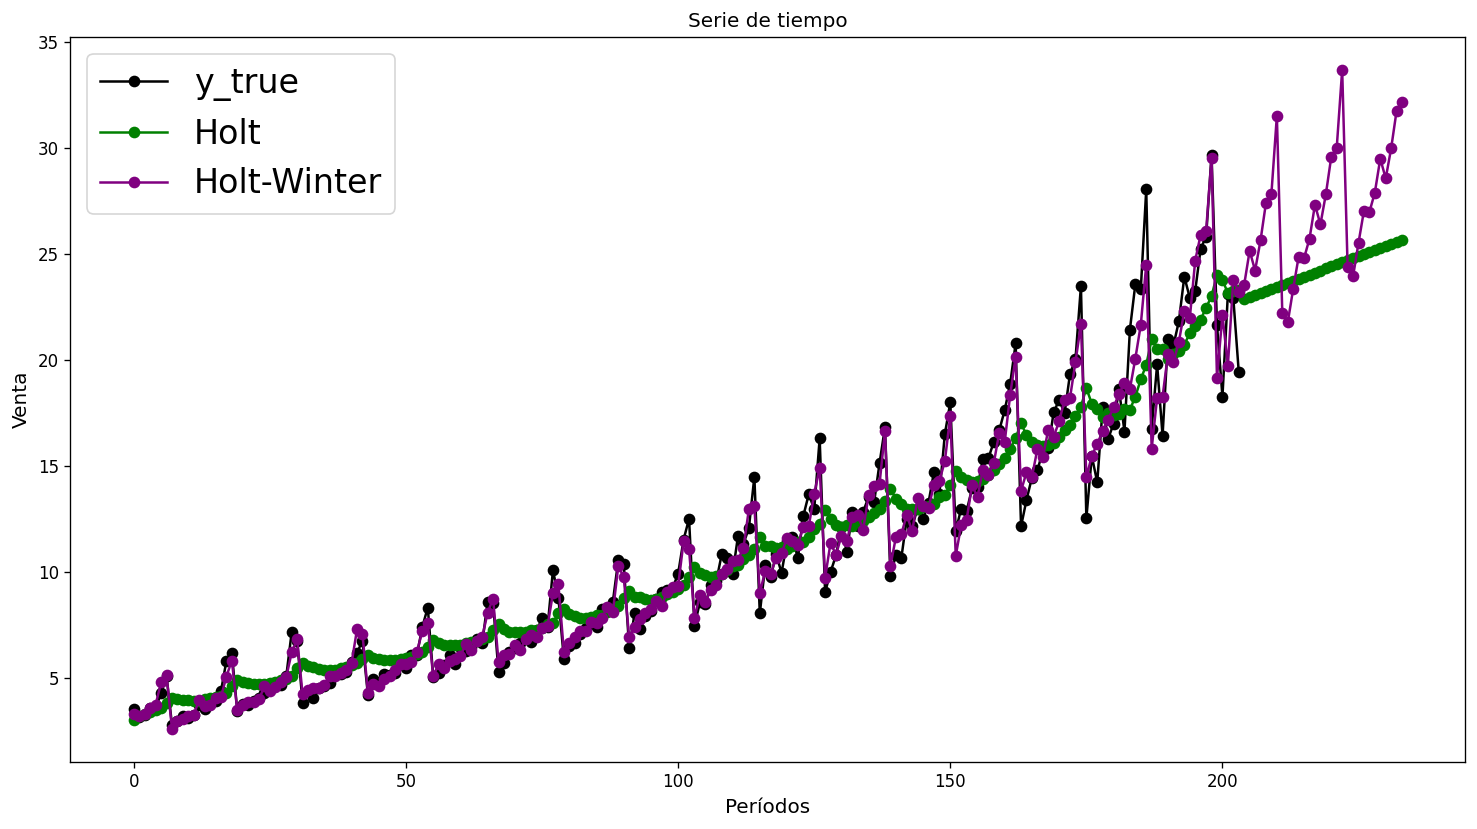

In [392]:
# Graficamos el entrenamiento y el forecast
plt.figure(figsize = [15,8])
plt.plot(df.index,df['value'], '-o',color = 'black', label = 'y_true')
plt.plot(holt_s, '-o',color = 'green', label = 'Holt')
plt.plot(holt_winter_s, '-o', color = 'purple', label = 'Holt-Winter')

plt.xlabel("Períodos", fontsize = 12)
plt.ylabel("Venta", fontsize = 12)
plt.title("Serie de tiempo")
plt.legend(loc = 'best', fontsize = 20)
plt.show()

In [393]:
# Calculamos el error 
#RMSE
from sklearn.metrics import mean_squared_error as MSE
#MAPE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Error Exponential Smoothing
print("RMSE Holt: ", MSE(df['value'],df['Holt'], squared = True))
print("RMSE Holt-Winter: ", MSE(df['value'],df['Holt-Winter'], squared = True))

print("******")

print("MAPE Holt : ", MAPE(df['value'],df['Holt']))
print("MAPE Holt-Winter : ", MAPE(df['value'],df['Holt-Winter']))

RMSE Holt:  3.865013748287052
RMSE Holt-Winter:  0.8424796204740733
******
MAPE Holt :  0.13650105723158265
MAPE Holt-Winter :  0.05018454954142515


# ARIMA

En estadística y econometría, en particular en series temporales, un modelo autorregresivo integrado de promedio móvil o ARIMA (acrónimo del inglés autoregressive integrated moving average) es un modelo estadístico que utiliza variaciones y regresiones de datos estadísticos con el fin de encontrar patrones para una predicción hacia el futuro. Se trata de un modelo dinámico de series temporales, es decir, las estimaciones futuras vienen explicadas por los datos del pasado y no por variables independientes.

ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary


https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

## Lectura del Dataset

In [394]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    204 non-null    datetime64[ns]
 1   value   204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB
None


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


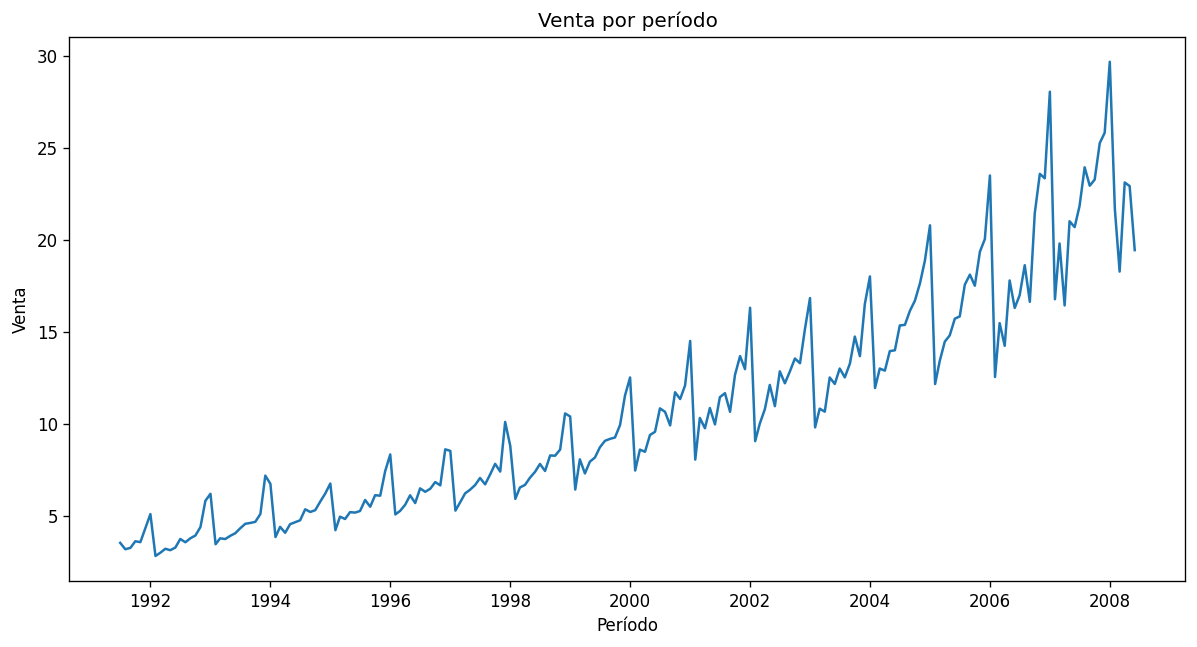

In [395]:
# Graficamos
plt.figure(figsize = [12,6])
plt.plot(df.date,df.value)
plt.xlabel("Período")
plt.ylabel("Venta")
plt.title("Venta por período")
plt.show()

Esta serie contiene estacionalidad por lo cual ARIMA NO es el mejor método, habria que utilizar SARIMA

## Parámetros

### Hallar Valor (d) nivel de diferenciación

#### Test Dickey Fuller

El proposito de "d" es hacer la serie estacionaria

El test Dickey Fuller (ADF)se utiliza para comprobar si la serie de tiempo es estacionaria (constante)

La hipotesis nula del test es que la serie NO es estacionaria

Entonces si el p valor es mayor al nivel de significancia rechazamos hipotesis nula (Nivel de significancia 0.05)


In [396]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


El p valor es mayor a 0.05 entonces NO rechazamos hipotesis nula y decimos que NO hay evidencia de que la serie estacionaria

#### Calcular d

Graficamos las series con distintos niveles de diferenciacion y el grafico de autocorrelación

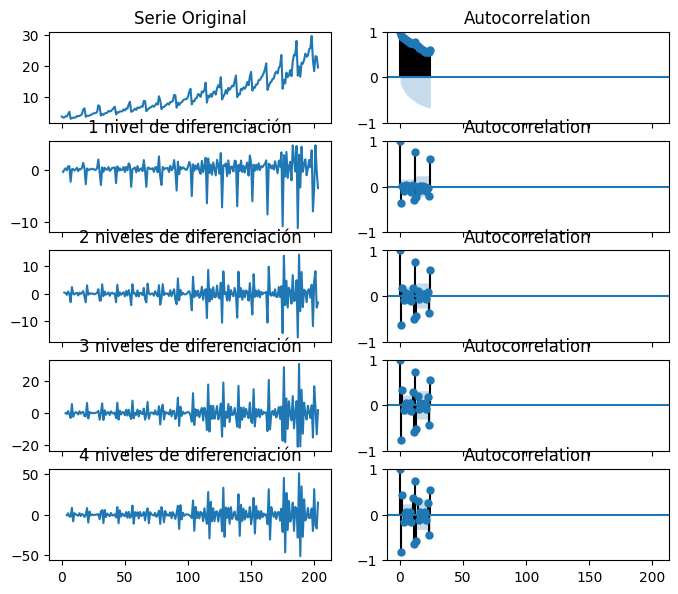

In [397]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(8,7), 'figure.dpi':100})

# serie original
fig, axes = plt.subplots(5, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Serie Original')
plot_acf(df.value, ax=axes[0, 1])

# 1 nivel de diferenciación
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1 nivel de diferenciación')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2 niveles de diferenciación
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2 niveles de diferenciación')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

# 3 niveles de diferenciación
axes[3, 0].plot(df.value.diff().diff().diff()); axes[3, 0].set_title('3 niveles de diferenciación')
plot_acf(df.value.diff().diff().diff().dropna(), ax=axes[3, 1])

#4 niveles de diferenciación
axes[4, 0].plot(df.value.diff().diff().diff().diff()); axes[4, 0].set_title('4 niveles de diferenciación')
plot_acf(df.value.diff().diff().diff().diff().dropna(), ax=axes[4, 1])

plt.show()

In [398]:
# Calculamos el adfuller test de vuelta
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value 1 nivel diferenciación: %f' % result[1])

result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value 2 niveles diferenciación: %f' % result[1])

ADF Statistic: -2.495172
p-value 1 nivel diferenciación: 0.116653
ADF Statistic: -10.292305
p-value 2 niveles diferenciación: 0.000000


Se observa que se rechaza la hipotesis nula a partir del segundo nivel de diferenciación

**d = 2**

### Hallar Valor (p) el termino de auto correlación parcial

#### Teoría

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

#### Visualización

IMPORTANTE :

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

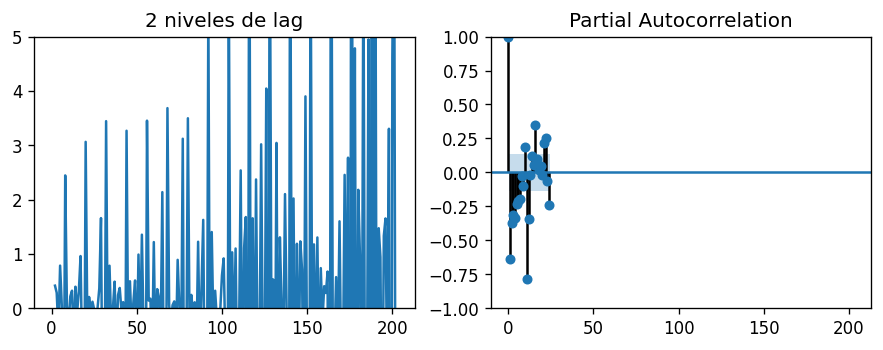

In [399]:
# Grafico de autocorrelación parcial para 2 niveles de promedio movil
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff().diff()); axes[0].set_title('2 niveles de lag')
axes[0].set(ylim=(0,5))
axes[1].set(ylim=(0,1))

plot_pacf(df.value.diff().diff().dropna(), ax=axes[1])

plt.show()

EL lag igual a 2 es significativo ya que los puntos están sobre el nivel de significancia (representado en la región azul clara)

**p = 2**

### Hallar Valor (q) de promedios móviles

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

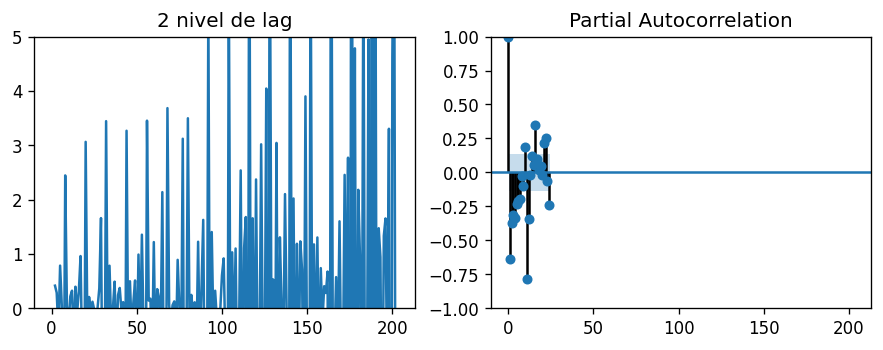

In [400]:
# Grafico de autocorrelación parcial para 1 nivel de promedio movil
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff().diff()); axes[0].set_title('2 nivel de lag')
axes[0].set(ylim=(0,5))
axes[1].set(ylim=(0,1))

plot_pacf(df.value.diff().diff().dropna(), ax=axes[1])

plt.show()

con  2 se observa que los puntos estan sobre el nivel de significancia

configuraremos **q = 1**, para hacer el modelo más simple

## Construir Modelo

In [401]:
# Libreria
import statsmodels.api as sm

# d = 2 , p = 2, q = 1 ARIMA Model
model=sm.tsa.arima.ARIMA(df.value, order=(2,2,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -435.944
Date:                Sun, 19 Jun 2022   AIC                            879.888
Time:                        02:14:52   BIC                            893.121
Sample:                             0   HQIC                           885.242
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4198      0.060     -6.959      0.000      -0.538      -0.302
ar.L2         -0.1463      0.071     -2.059      0.040      -0.286      -0.007
ma.L1         -0.9999      2.696     -0.371      0.7

Todos son significantes excepto "ar.L2.D2.value" el cual representa el segundo nivel de auto regresión "p", haremos de nuevo el modelo sin este nivel

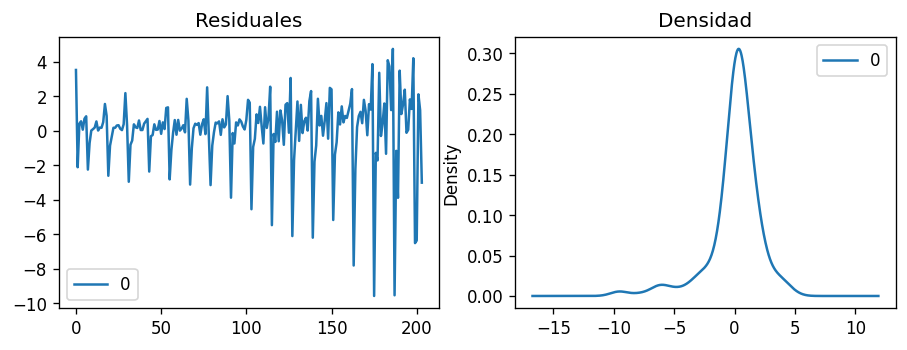

In [402]:
# Graficamos los errores residuales

residuales = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuales.plot(title="Residuales", ax=ax[0])
residuales.plot(kind='kde', title='Densidad', ax=ax[1])
plt.show()

Los errores residuales tienen buena forma, con media cercana a cero y una varianza uniforme

## Predicción

#### Entrenamiento

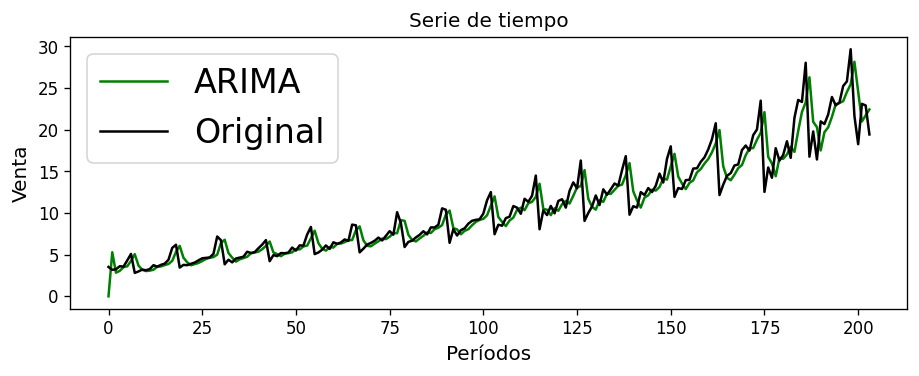

In [403]:
# Verdadero vs ajuste

predict=model_fit.predict()
plt.plot(predict, color = 'green', label = 'ARIMA') 
plt.plot(df.value,color = 'black', label = 'Original')
plt.xlabel("Períodos", fontsize = 12)
plt.ylabel("Venta", fontsize = 12)
plt.title("Serie de tiempo")
plt.legend(loc = 'best', fontsize = 20)
plt.show()

#### Validación

Ahora hacemos varios pasos hacia atrás, predecimos con el modelo y observamos con los valores reales

In [404]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])

In [405]:
# Libreria
from statsmodels.tsa.stattools import acf

print( "Longitud de la serie de tiempo",len(df))

#Dividiamos en un ratio 70/30 el train y validation
train = df.value[:160]
print("Longitud data de entrenamiento", len(train))
test = df.value[160:]
print("Longitud data de validación", len(test))


Longitud de la serie de tiempo 204
Longitud data de entrenamiento 160
Longitud data de validación 44


In [406]:
# Construimos modelo
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train, order=(2, 2, 1))  
fitted = model.fit()  
fitted

In [407]:
# Forecast
fc = fitted.get_forecast(44,alpha = 0.05).predicted_mean # se predicen 44 valores
print(fc.head())
#Intervalo de confianza
conf = fitted.get_forecast(44,alpha = 0.05).conf_int() 
print(type(conf))
conf.head()

160    16.435866
161    16.551195
162    16.691370
163    16.743211
164    16.824929
Name: predicted_mean, dtype: float64
<class 'pandas.core.frame.DataFrame'>


,lower value,upper value
160,13.542859,19.328872
161,13.165985,19.936405
162,12.944045,20.438694
163,12.528556,20.957866
164,12.221784,21.428074


In [408]:
# Transformarlo en pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = conf.iloc[:,0]
upper_series = conf.iloc[:,1]
lower_series.head()

160    13.542859
161    13.165985
162    12.944045
163    12.528556
164    12.221784
Name: lower value, dtype: float64

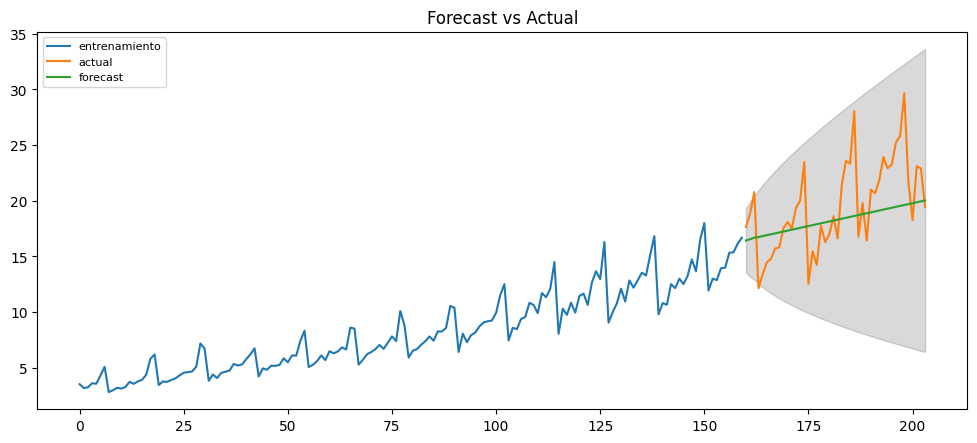

In [409]:
#Graficamos
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='entrenamiento')
plt.plot(test, label='actual')
plt.plot(fc, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Error

In [410]:
# Error ARIMA
print("RMSE : ", MSE(fc,test.values, squared = False))
print("MAPE : ", MAPE(fc,test.values))

RMSE :  3.662384712263885
MAPE :  0.15994706151840934


In [411]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fc, test.values)

{'acf1': 0.41611975691296366,
 'corr': 0.6215371397672433,
 'mae': 2.942116486305615,
 'mape': 0.14772834279994349,
 'me': -1.2190125647052834,
 'minmax': 0.1370413577434385,
 'mpe': -0.028848712200516723,
 'rmse': 3.662384712263885}

# AUTO-ARIMA

Python busca combinaciones de p,d,q hasta encontrar aquella que mejor ajusta el modelo

## Creación

In [412]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])

In [413]:
# Separamos en train y test 70/30 aprox
#Dividiamos en un ratio 70/30 el train y validation
print("Longitud data total", len(df))


train = df.iloc[:160,:]
print("Longitud data de entrenamiento", len(train))

test = df.iloc[160:,:]
print("Longitud data de validación", len(test))


len(train)
train.head()


Longitud data total 204
Longitud data de entrenamiento 160
Longitud data de validación 44


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [414]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(train.value, start_p=1, start_q=1,
                      test='adf',       # usar adftest para encontrar 'd' optimo
                      max_p=3, max_q=3, # maximos de p and q
                      m=1,              # frecuencia
                      d=None,           # que el modelo estime 'd'
                      seasonal=False,   # Sin estacionalidad
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=580.430, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1161.220, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=610.744, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=994.173, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=572.498, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=574.457, Time=0.25 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=581.366, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=573.182, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=590.139, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=573.036, Time=0.32 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 2.144 seconds
                               SARIMAX Results                                
Dep. Variable:              

## Validación

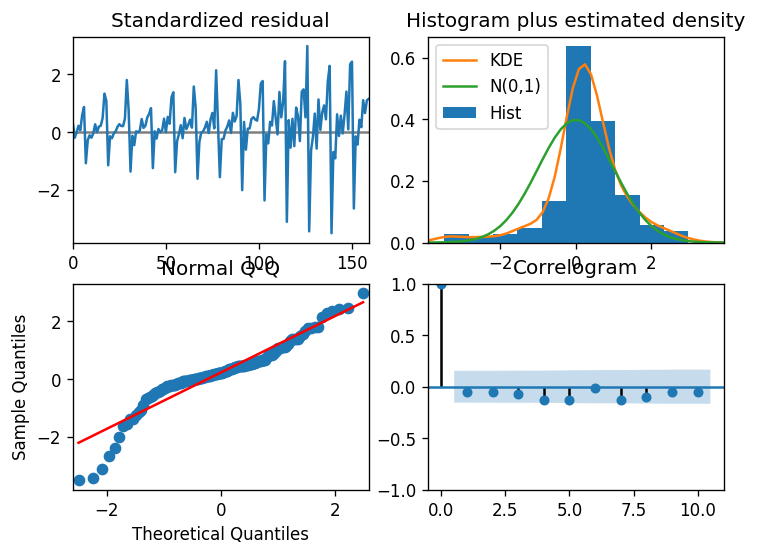

In [415]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

Arriba la izquierda: los errores residuales fluctuan alrededor de 0 y la varianza no es constante

Arriba a la derecha: el grafico de densided tiene distribución normal con media cercana a a cero

Abajo a la izquierda: existe cierto sesgo en los datos ya que no estan siempre encima de la franja roja

Abajo a la derecha: el correlograma no muestra un patron por lo que podemos decir que los errores residuales no están correlacionados. Cualquier patrón indicaria que si estpan correlacionados y nos falta agregar predictores "x" al modelo

In [416]:
# Forecast
n_periods = len(test)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

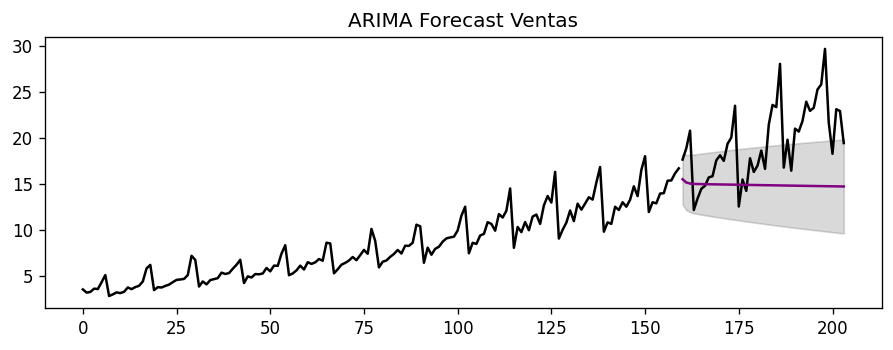

In [417]:
# Ajustamos a Series para Graficar Correctamente la media y los IC
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)
fitted_series = pd.Series(fc, index=test.index)

#Graficamos
plt.plot(test.value, color='black', label = 'Original')
plt.plot(train.value, color='black', label = 'Original')

plt.plot(fitted_series, color='purple',label = 'ARIMA')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA Forecast Ventas")
plt.show()
plt.show()

## Error

In [418]:
# Tranformamos la predicción a un numpy-array
test_np = test.value.to_numpy()
# Error AUTO-ARIMA
print("RMSE : ", MSE(fc,test_np, squared = False))
print("MAPE : ", MAPE(fc,test_np))

RMSE :  6.1466602378993835
MAPE :  0.33575818120200995


## Forecast

In [419]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])

In [420]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # usar adftest para encontrar 'd' optimo
                      max_p=3, max_q=3, # maximos de p and q
                      m=1,              # frecuencia
                      d=None,           # que el modelo estime 'd'
                      seasonal=False,   # Sin estacionalidad
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.49 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.49 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.834, Time=0.63 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

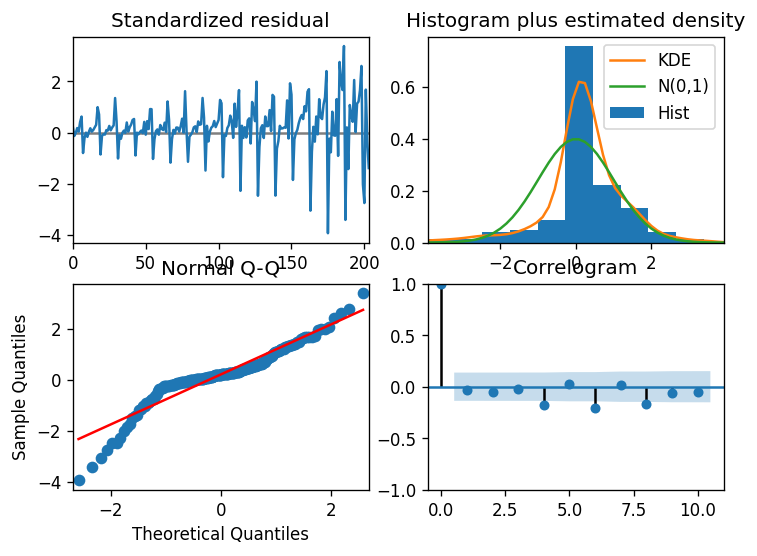

In [421]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

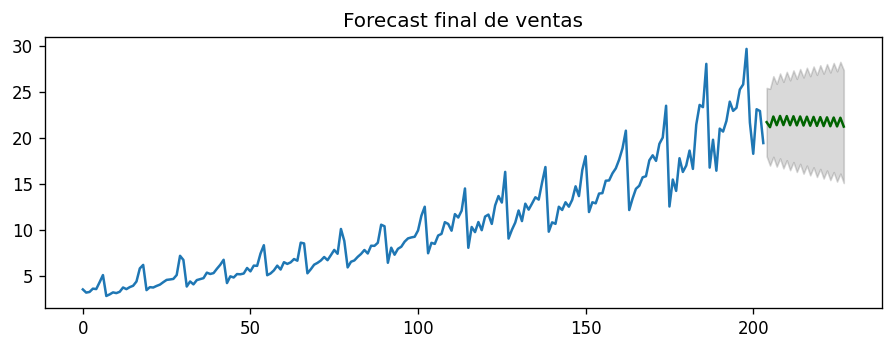

In [422]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Forecast final de ventas")
plt.show()

# SARIMA

Permite evaluar series de tiempo con estacionalidad

Haremos diferenciales normales contra diferenciales de 12 meses para observar el componente de estacionalidad

In [423]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])

## Creación

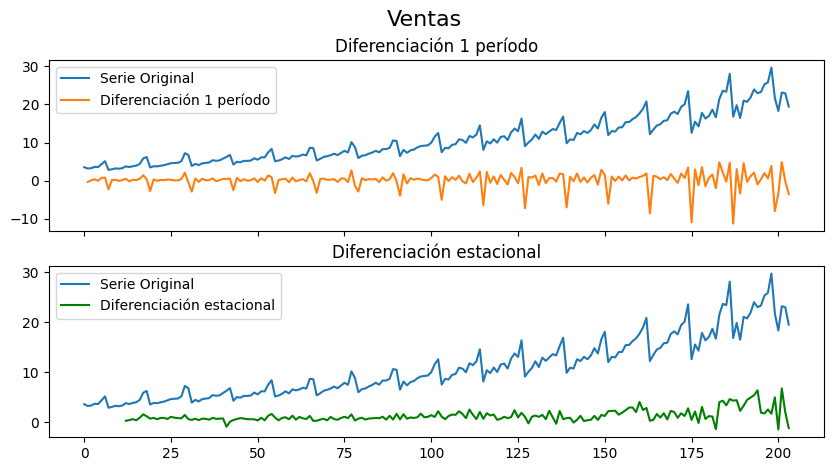

In [424]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Diferenciación usual de 1 período
axes[0].plot(df.value, label='Serie Original')
axes[0].plot(df.value.diff(1), label='Diferenciación 1 período')
axes[0].set_title('Diferenciación 1 período')
axes[0].legend(loc='upper left', fontsize=10)


# Diferenciación de 12 períodos
axes[1].plot(df.value, label='Serie Original')
axes[1].plot(df.value.diff(12), label='Diferenciación estacional', color='green')
axes[1].set_title('Diferenciación estacional')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas', fontsize=16)
plt.show()

Se observa que la diferenciación de 12 meses es correcta pq los picos desaparecen del grafico, mientras que con la rectificación normal se mantienen 

In [425]:
# Separamos en train y test 70/30 aprox
#Dividiamos en un ratio 70/30 el train y validation
print("Longitud data total", len(df))


train = df.iloc[:160,:]
print("Longitud data de entrenamiento", len(train))

test = df.iloc[160:,:]
print("Longitud data de validación", len(test))


len(train)
train.head()


Longitud data total 204
Longitud data de entrenamiento 160
Longitud data de validación 44


,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [426]:
import pmdarima as pm

# Auto ARIMA con estacionalidad
smodel = pm.auto_arima(train.value, start_p=1, start_q=1, #valores iniciales de "p" y "q"
                         test='adf', # utilizar dickey-fuller test para encontrar "d"
                         max_p=3, max_q=3, m=12, # valores meximos de p, q. frecuencia estacional = 12
                         start_P=0, seasonal=True, # configuramos la estacionalidad
                         d=None, D=1, trace=True, # D=1 diferenciacion en 1 periodo de los 12 configurados
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=237.017, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=318.137, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=269.276, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=238.450, Time=0.29 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=240.700, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=236.219, Time=0.61 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=239.037, Time=0.23 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=237.022, Time=1.29 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=237.446, Time=1.72 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=235.487, Time=0.96 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=236.251, Time=0.76 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=261.690, Time=0.61 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=237.161, Time=1.78 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=237.392, Time=1.42 sec
 ARIMA(0,1,0)(0,1,2)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  160
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -112.716
Date:                            Sun, 19 Jun 2022   AIC                            235.433
Time:                                    02:15:21   BIC                            250.385
Sample:                                         0   HQIC                           241.508
                                            - 160                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8624      0.086    -10.072      0.000      -1.030      -0.695
ma.L2          0.1419      0.083      1.705      0.088      -0.021       0.305
ma.S.L12      -0.2259      0.084     -2.704      0.007      -0.390      -0.062
ma.S.L24      -0.1509      0.089     -1.701      0.089      -0.325       0.023
sigma2         0.2671      0.029      9.369      0.000       0.211       0.323
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 4.05
Prob(Q):                              0.82   Prob(JB):                         0.13
Heteroskedasticity (H):               3.32   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Validación

In [427]:
# Forecast
n_periods = len(test)
fc, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

# make series for plotting purpose
fitted_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

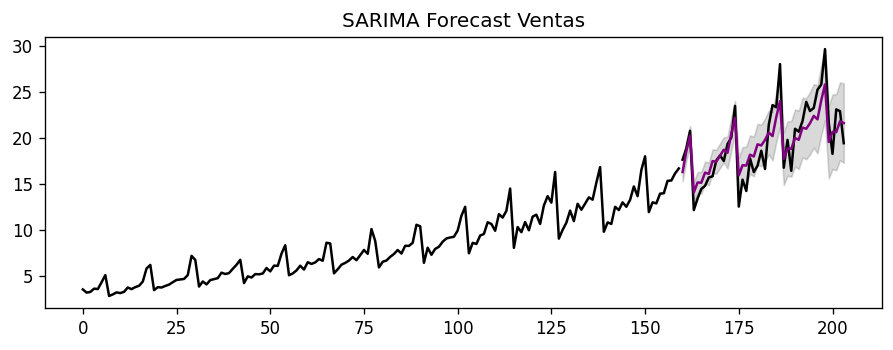

In [428]:
# Ajustamos a Series para Graficar Correctamente la media y los IC
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)
fitted_series = pd.Series(fc, index=test.index)

#Graficamos
plt.plot(test.value, color='black', label = 'Original')
plt.plot(train.value, color='black', label = 'Original')

plt.plot(fitted_series, color='purple',label = 'SARIMA')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast Ventas")
plt.show()
plt.show()

## Error

In [429]:
# Tranformamos la predicción a un numpy-array
test_np = test.value.to_numpy()
# Error SARIMA
print("RMSE : ", MSE(fc,test_np, squared = False))
print("MAPE : ", MAPE(fc,test_np))

RMSE :  1.9055511270488679
MAPE :  0.08216522763968943


## Forecast

Ahora utilizamos todo el dataset para predecir

In [430]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'])

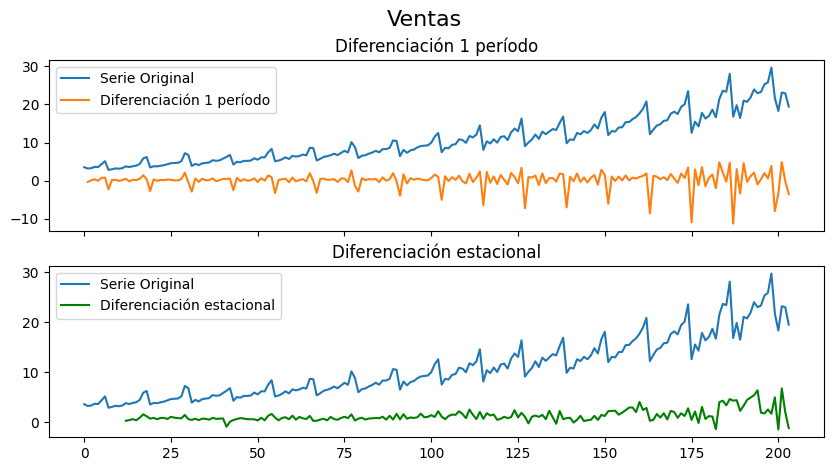

In [431]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Diferenciación usual de 1 período
axes[0].plot(df.value, label='Serie Original')
axes[0].plot(df.value.diff(1), label='Diferenciación 1 período')
axes[0].set_title('Diferenciación 1 período')
axes[0].legend(loc='upper left', fontsize=10)


# Diferenciación de 12 períodos
axes[1].plot(df.value, label='Serie Original')
axes[1].plot(df.value.diff(12), label='Diferenciación estacional', color='green')
axes[1].set_title('Diferenciación estacional')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas', fontsize=16)
plt.show()

In [432]:
import pmdarima as pm

# Auto ARIMA con estacionalidad
smodel = pm.auto_arima(df.value, start_p=1, start_q=1, #valores iniciales de "p" y "q"
                         test='adf', # utilizar dickey-fuller test para encontrar "d"
                         max_p=3, max_q=3, m=12, # valores meximos de p, q. frecuencia estacional = 12
                         start_P=0, seasonal=True, # configuramos la estacionalidad
                         d=None, D=1, trace=True, # D=1 diferenciacion en 1 periodo de los 12 configurados
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.31 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=4.15 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=2.30 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.874, Time=5.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.31 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.77 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.35 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.032
Date:                            Sun, 19 Jun 2022   AIC                            524.065
Time:                                    02:17:28   BIC                            550.125
Sample:                                         0   HQIC                           534.619
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.009      0.551      0.582      -0.013       0.023
ar.L1          0.9763      0.018     52.918      0.000       0.940       1.012
ma.L1         -0.8964      0.056    -15.894      0.000      -1.007      -0.786
ma.L2          0.2027      0.058      3.500      0.000       0.089       0.316
ar.S.L12       0.8479      0.175      4.851      0.000       0.505       1.191
ma.S.L12      -1.5592      0.194     -8.043      0.000      -1.939      -1.179
ma.S.L24       0.7299      0.114      6.384      0.000       0.506       0.954
sigma2         0.7603      0.063     12.003      0.000       0.636       0.884
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               142.10
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):              14.53   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [433]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

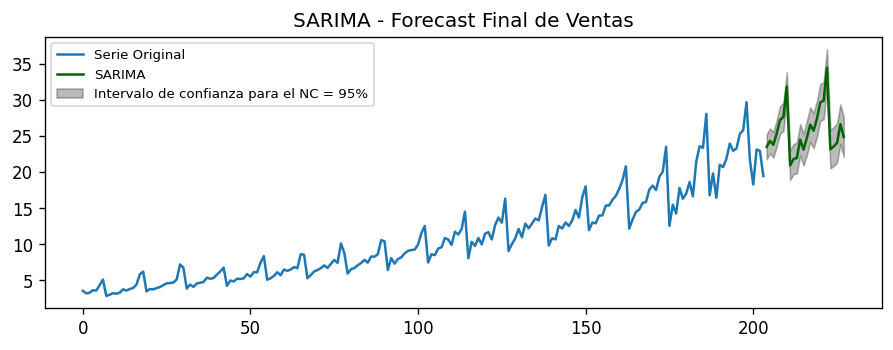

In [434]:
# Plot
plt.plot(df.value, label = 'Serie Original')
plt.plot(fitted_series, color='darkgreen', label = 'SARIMA')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.27, label = 'Intervalo de confianza para el NC = 95%')
plt.legend(loc = 'best', fontsize = 8)
plt.title("SARIMA - Forecast Final de Ventas")
plt.show()

# SARIMAX

Se le agrega una variable "exogena" al modelo, es una predictora externa

El indice de estacionalidad se le va a agregar como variable externa, expcificamente el indice cercano de estacionalidad se le agrega tanto al ajuste como al forecast a ver como cambia la predicción, es buen ejemplo ya que es fijo cada 12 meses

Este ejemplo sirve para todo y se le puede agregar otra variable exogena al modelo solo cambiando la variable, todo lo demás se mantiene igual

In [435]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'], index_col='date')

Ejercicio de como trabajar la fecha como indice del dataframe

## Cálculo Variable Exogena

In [436]:
# Calcular el indica estacional
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# La componente estacional multiplicativa
result_mul = seasonal_decompose(data['value'][-36:],   # componente estacional de 3 años
                                model='multiplicative',  # la variable multiplica al modelo
                                extrapolate_trend='freq')

#Dataframe con la variable nueva en meses
seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['mes'] = pd.to_datetime(seasonal_index.index).month

# Merge para tener nuestro Dataset consolidado
data['mes'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='mes')
df.columns = ['value', 'mes', 'seasonal_index']
df.index = data.index  # ordenamos de nuevo el indice del dataset.
df.head()

,value,mes,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


In [437]:
#Dividiamos en un ratio 70/30 el train y validation
print("Longitud data total", len(df))


train = df.iloc[:160,:]
print("Longitud data de entrenamiento", len(train))

test = df.iloc[160:,:]
print("Longitud data de validación", len(test))


len(train)
train.head()

Longitud data total 204
Longitud data de entrenamiento 160
Longitud data de validación 44


,value,mes,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


## Creación

In [438]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(train[['value']], exogenous=train[['seasonal_index']], # indicamos variable exogena
                           start_p=1, start_q=1, # valores iniciales de "p" y "q"
                           test='adf', #Dickey-Fuller test para encontrar valor de "d"
                           max_p=3, max_q=3, m=12, # valores max de "p" y "q", 12 meses de estacionalidad 
                           start_P=0, seasonal=True, # estacionalidad activada
                           d=None, D=1, trace=True, # D=1 para serie con estacionalidad
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=244.569, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=284.246, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=269.733, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=276.143, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=453.718, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=246.923, Time=0.49 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=242.622, Time=3.75 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=278.051, Time=0.92 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=270.659, Time=0.97 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=241.772, Time=4.91 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=243.086, Time=1.78 sec
 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  160
Model:             SARIMAX(1, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -112.831
Date:                            Sun, 19 Jun 2022   AIC                            241.663
Time:                                    02:18:44   BIC                            265.640
Sample:                                07-01-1991   HQIC                           251.405
                                     - 10-01-2004                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0303      0.040      0.767      0.443      -0.047       0.108
seasonal_index  1.304e-06    4.8e-09    271.443      0.000    1.29e-06    1.31e-06
ar.L1              0.9695      0.042     23.177      0.000       0.887       1.051
ma.L1             -0.8415      0.094     -8.986      0.000      -1.025      -0.658
ma.L2              0.1465      0.087      1.689      0.091      -0.023       0.316
ma.S.L12          -0.2243      0.085     -2.642      0.008      -0.391      -0.058
ma.S.L24          -0.1472      0.090     -1.639      0.101      -0.323       0.029
sigma2             0.2649      0.029      9.282      0.000       0.209       0.321
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.93   Prob(JB):                         0.26
Heteroskedasticity (H):               3.26   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.83e+16. Standard errors may be unstable.
"""

## Validación

In [439]:
# Forecast
n_periods = len(test)
fc, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=test[['seasonal_index']], 
                                  return_conf_int=True)

index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS') # Indice en meses


In [440]:
test.head()

,value,mes,seasonal_index
date,,,
2004-11-01,17.636728,11,1.146141
2004-12-01,18.869325,12,1.150750
2005-01-01,20.778723,1,1.316913
2005-02-01,12.154552,2,0.803279
2005-03-01,13.402392,3,0.850667


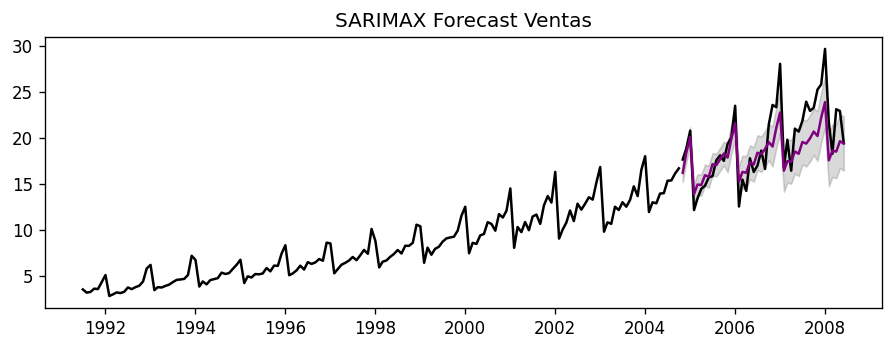

In [441]:
# Ajustamos a Series para Graficar Correctamente la media y los IC
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)
fitted_series = pd.Series(fc, index=test.index)

#Graficamos
plt.plot(test.value, color='black', label = 'Original')
plt.plot(train.value, color='black', label = 'Original')

plt.plot(fitted_series, color='purple',label = 'SARIMAX')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast Ventas")
plt.show()
plt.show()

## Error

In [442]:
# Tranformamos la predicción a un numpy-array
test_np = test.value.to_numpy()
# Error SARIMAX
print("RMSE : ", MSE(fc,test_np, squared = False))
print("MAPE : ", MAPE(fc,test_np))

RMSE :  2.5022467391197476
MAPE :  0.10379571605998582


## Forecast

Tomamos todo el dataset como entrenamiento en lugar de dividirlo en train y test

In [443]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates = ['date'], index_col='date')
data.head()


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [444]:
# Calcular el indica estacional
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# La componente estacional multiplicativa
result_mul = seasonal_decompose(data['value'][-36:],   # 3 años
                                model='multiplicative',  # la variable multiplica al modelo
                                extrapolate_trend='freq')

#Dataframe con la variable nueva en meses
seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['mes'] = pd.to_datetime(seasonal_index.index).month

# Merge para tener nuestro Dataset consolidado
data['mes'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='mes')
df.columns = ['value', 'mes', 'seasonal_index']
df.index = data.index  # ordenamos de nuevo el indice del dataset.
df.head()

,value,mes,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


In [445]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']], # indicamos variable exogena
                           start_p=1, start_q=1, # valores iniciales de "p" y "q"
                           test='adf', #Dickey-Fuller test para encontrar valor de "d"
                           max_p=3, max_q=3, m=12, # valores max de "p" y "q", 12 meses de estacionalidad 
                           start_P=0, seasonal=True, # estacionalidad activada
                           d=None, D=1, trace=True, # D=1 para serie con estacionalidad
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=1.49 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.14 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.37 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=5.23 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=1.52 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.543, Time=5.68 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.41 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=1.47 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.47 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.951
Date:                            Sun, 19 Jun 2022   AIC                            525.903
Time:                                    02:21:01   BIC                            555.220
Sample:                                07-01-1991   HQIC                           537.777
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0052      0.009      0.581      0.561      -0.012       0.023
seasonal_index  1.321e-06   1.93e+04   6.83e-11      1.000   -3.79e+04    3.79e+04
ar.L1              0.9767      0.019     52.701      0.000       0.940       1.013
ma.L1             -0.9107      0.057    -15.998      0.000      -1.022      -0.799
ma.L2              0.2165      0.059      3.652      0.000       0.100       0.333
ar.S.L12           0.8422      0.155      5.436      0.000       0.539       1.146
ma.S.L12          -1.5844      0.176     -8.996      0.000      -1.930      -1.239
ma.S.L24           0.7671      0.111      6.908      0.000       0.549       0.985
sigma2             0.7476      0.066     11.333      0.000       0.618       0.877
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               142.62
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              14.47   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El indice de estacionalidad que agregamos al principio no es estadisticamente significativo, los demás regresores si

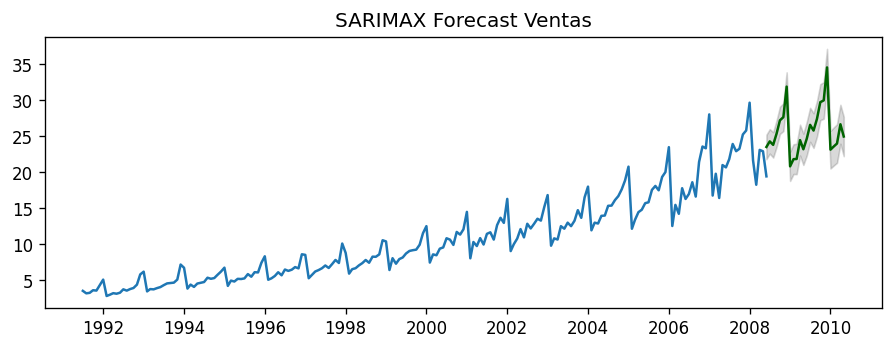

In [446]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS') # Indice en meses

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast Ventas")
plt.show()

In [447]:
end_time = time.time()

print("Minutos :",(end_time - start_time)/ 60)

Minutos : 6.3443712512652075


# Comparación de Modelos

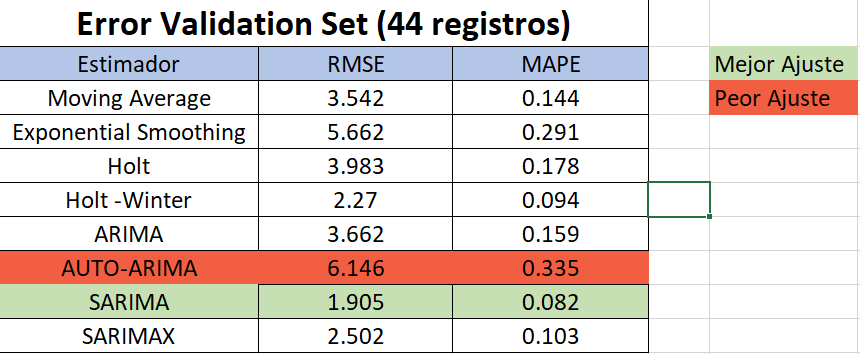